In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline
from sklearn.metrics import accuracy_score

import sklearn.linear_model

In [2]:
def plot_surface(cls, x_1, x_2, ax=None, threshold=0.5, contourf=False):
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))

    X_pred = np.c_[xx1.ravel(), xx2.ravel()]
    pred = cls.predict_proba(X_pred)[:, 0]
    Z = pred.reshape((100, 100))
    if ax is None:
        ax = plt.gca()
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))

In [3]:
def plot_data(X, y):
    ax = plt.gca()
    ax.scatter(X[:,0], X[:,1], c=(y == 1), cmap=cm_bright)

In [4]:
class NeuralNet:
    """
    NN for binary classification
    Attributes:
    ...
    """
    
    def __init__(self, normalize = True, learning_rate = 0.01, num_iter = 30000):
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
    
    def __normalize(self, X, mean = None, std = None):
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s**2
        return X_new, m, s

    def __sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
    
    def __softmax(self, Z):
        return exp(Z);
    
    def __initialize_parameters(self, n_x, n_1):
        W1 = np.random.randn(n_1, n_x) * 0.01
        b1 = np.zeros((n_1, 1))
        W2 = np.random.randn(1, n_1) * 0.01
        b2 = 0
        self.parameters = {"W1" : W1, "b1" : b1, "W2" : W2, "b2" : b2}
       
    def __forward_propagation(self, X):
        W1 = self.parameters["W1"]
        b1 = self.parameters["b1"]
        W2 = self.parameters["W2"]
        b2 = self.parameters["b2"]

        Z1 = np.dot(W1, X) + b1
        A1 = self.__sigmoid(Z1)

        Z2 = np.dot(W2, A1) + b2
        A2 = self.__sigmoid(Z2)

        
        cache = (W1, b1, W2, b2, Z1, A1, Z2, A2)

        return A2, cache
    
    def compute_cost(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        return J
        
    def __backward_propagation(self, X, Y, cache):
        m = X.shape[1]
        n = X.shape[0]
        (W1, b1, W2, b2, Z1, A1, Z2, A2) = cache
        
        dZ2 = A2 - Y
        dW2 = 1. / m * np.dot(dZ2, A1.T)
        db2 = 1. / m * np.sum(dZ2, axis = 1, keepdims = True)
        
        dA1 = np.dot(W2.T, dZ2)
        dZ1 = np.multiply(dA1, np.multiply(A1, 1 - A1))
        dW1 = 1. / m * np.dot(dZ1, X.T)
        db1 = 1. / m * np.sum(dZ1, axis = 1, keepdims = True)
        

        grads = {"dZ1" : dZ1, "dW1" : dW1, "db1" : db1, "dZ2" : dZ2, "dW2" : dW2, "db2" : db2}
        return grads
    
    def __update_parameters(self, grads):
        W1 = self.parameters["W1"]
        b1 = self.parameters["b1"]
        W2 = self.parameters["W2"]
        b2 = self.parameters["b2"]

        dW1 = grads["dW1"]
        db1 = grads["db1"]
        dW2 = grads["dW2"]
        db2 = grads["db2"]
        

        self.parameters["W1"] = W1 - self.learning_rate * dW1
        self.parameters["b1"] = b1 - self.learning_rate * db1
        self.parameters["W2"] = W2 - self.learning_rate * dW2
        self.parameters["b2"] = b2 - self.learning_rate * db2

        
    def fit(self, X_vert, Y_vert, print_cost = True):
        
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        
        m = X.shape[1]
        n_x = X.shape[0]
        
        self.__initialize_parameters(n_x, 20)

        for i in range(self.num_iter):
            A, cache = self.__forward_propagation(X)

            cost = self.compute_cost(A, Y)

            grads = self.__backward_propagation(X, Y, cache)

            self.__update_parameters(grads)

            if print_cost and i % 1000 == 0:
                print("{}-th iteration: {}".format(i, cost))

            if i % 1000 == 0:
                costs.append(cost)

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *1000")
            plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0]
        
        return np.column_stack((probs.T, 1 - probs.T))
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)[:, 0]
        return (positive_probs >= 0.5).astype(int)   


In [5]:
#data_columns = ["exam1", "exam2"]
#target_column = "submitted"
#df = pd.read_csv("sats.csv")
#X, Y = df[data_columns].values, df[target_column].reshape((df.shape[0], 1))
#print('Training set: X={}, y={}'.format(X.shape, Y.shape))

In [6]:
data_columns = ["test1", "test2"]
target_column = "passed"
df = pd.read_csv("tests.csv")
X, Y = df[data_columns].values, df[target_column]
print('Training set: X={}, y={}'.format(X.shape, Y.shape))

Training set: X=(118, 2), y=(118,)


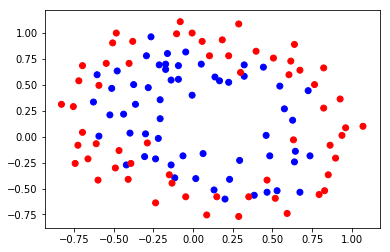

In [7]:
plot_data(X, Y)

In [8]:
cls = NeuralNet(normalize = True, learning_rate = 0.5, num_iter = 4000)

0-th iteration: 0.6934572394471675
1000-th iteration: 0.6892700722511547
2000-th iteration: 0.58145798723219
3000-th iteration: 0.3939619880566762


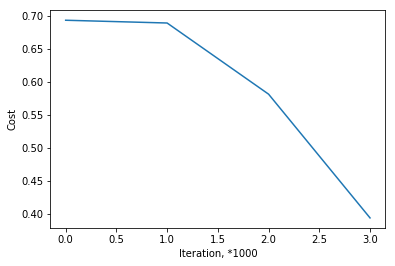

In [9]:
cls.fit(X, Y.values.reshape((df.shape[0], 1)))

In [10]:
print(cls.parameters)

{'W1': array([[ 0.17822063,  0.13336529],
       [ 0.99316016, -0.19281162],
       [ 0.86276836, -0.23505125],
       [ 0.65048348,  1.27926908],
       [ 0.12442243,  0.33314721],
       [ 0.25410741,  0.18658174],
       [ 1.03062976, -0.08323603],
       [ 0.02790963,  0.31366471],
       [ 1.3474159 , -0.37588104],
       [ 0.23887007,  0.12794319],
       [ 0.9594891 , -0.23218989],
       [ 0.24459962,  0.12681939],
       [ 0.45942393, -3.52231996],
       [ 0.18141843,  0.20954135],
       [-0.37448373,  1.60956114],
       [ 1.3185419 ,  0.23275438],
       [ 0.13860324,  0.28611576],
       [ 0.25615419, -1.62588316],
       [ 1.86026783,  1.48820719],
       [ 0.1793743 ,  0.22372717]]), 'b1': array([[-0.06230025],
       [ 1.25606459],
       [ 0.6684345 ],
       [ 2.53112467],
       [-0.13566091],
       [-0.03833807],
       [ 1.35751958],
       [-0.17156233],
       [ 3.45928177],
       [ 0.11142453],
       [ 1.57221538],
       [ 0.05429658],
       [-1.08161327],

In [16]:
Y_prob = cls.predict_proba(X)
Y_prob

array([[5.73975065e-01, 4.26024935e-01],
       [8.45810212e-01, 1.54189788e-01],
       [3.17449396e-01, 6.82550604e-01],
       [1.50443871e-01, 8.49556129e-01],
       [8.39625540e-02, 9.16037446e-01],
       [8.57547611e-01, 1.42452389e-01],
       [3.20378874e-02, 9.67962113e-01],
       [2.32315896e-01, 7.67684104e-01],
       [7.42336556e-01, 2.57663444e-01],
       [9.48522879e-01, 5.14771208e-02],
       [9.71058766e-01, 2.89412344e-02],
       [2.72613700e-01, 7.27386300e-01],
       [2.28040859e-01, 7.71959141e-01],
       [1.07179908e-01, 8.92820092e-01],
       [8.13999345e-01, 1.86000655e-01],
       [1.93570146e-01, 8.06429854e-01],
       [6.06939139e-01, 3.93060861e-01],
       [8.44211887e-01, 1.55788113e-01],
       [7.73049164e-01, 2.26950836e-01],
       [1.59092362e-01, 8.40907638e-01],
       [9.95482305e-01, 4.51769495e-03],
       [8.76427374e-01, 1.23572626e-01],
       [8.70281484e-01, 1.29718516e-01],
       [5.17219072e-02, 9.48278093e-01],
       [2.814389

In [17]:
Y_hat = cls.predict(X)
Y_hat

array([1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 0])

In [18]:
accuracy_score(Y, Y_hat)

0.8559322033898306

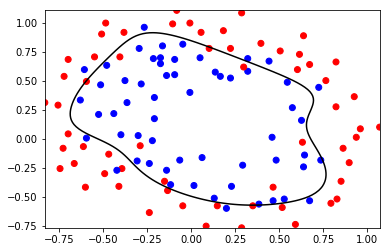

In [19]:
plot_data(X, Y)
plot_surface(cls, X[:, 0], X[:, 1])

In [49]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (20,), max_iter = 10000, activation = 'relu', solver = 'sgd', learning_rate_init = 0.01, learning_rate = 'constant')

In [50]:
clf.fit(X, Y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20,), learning_rate='constant',
       learning_rate_init=0.01, max_iter=10000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='sgd', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

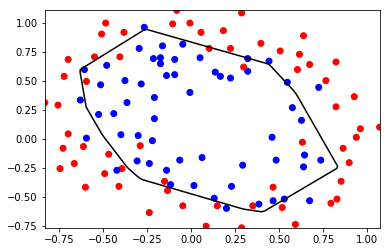

In [51]:
plot_data(X, Y)
plot_surface(clf, X[:, 0], X[:, 1])

In [48]:
accuracy_score(Y, clf.predict(X))

0.864406779661017